# HW2 Q3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd

In [2]:
uploaded = files.upload()

Saving Cities.csv to Cities (1).csv


In [3]:
cities = pd.read_csv('Cities.csv', sep=" ", header=None, index_col=0, names=["x", "y"])
print("number of cities: ", len(cities))
print("\ncities 1 to 4:")
print(cities[:4])

number of cities:  194

cities 1 to 4:
            x           y
1  24748.3333  50840.0000
2  24758.8889  51211.9444
3  24827.2222  51394.7222
4  24904.4444  51175.0000


In [4]:
# normalize
ratio = (cities.x.max() - cities.x.min()) / (cities.y.max() - cities.y.min()), 1
ratio = np.array(ratio) / max(ratio)
cities = cities.apply(lambda c: (c - c.min()) / (c.max() - c.min()))
cities = cities.apply(lambda p: ratio * p, axis=1)

cities_x = np.array(cities.x.values.tolist())
cities_y = np.array(cities.y.values.tolist())


cities_dataset = np.stack([cities_x, cities_y], axis=1)
cities_dataset.shape

(194, 2)

In [5]:
class Kohonen:
    def __init__(self, length, feature_size, radius, lr, time_constant_r=1, time_constant_lr=1):
        self.feature_size = feature_size
        self.w = None
        self.radius = radius
        self.lr = lr
        self.nodes_n = length
        self.iterations_n = 0
        self.time_constant_r = time_constant_r
        self.time_constant_lr = time_constant_lr    
        
        # Step 1: initialize
        self.initialize_weights()
        print("initialization complete")
        
        self.neighborhoods = self.find_all_neighborhoods()
        
    def find_all_neighborhoods(self):
        indices = np.arange(self.nodes_n)
        dists = []
        for x in range(self.nodes_n):
            d = np.abs(indices - x)
            d = np.minimum(d, self.nodes_n - d) # because we go back to neuron
            gaus_func = np.exp(- np.square(d) / (2 * np.square(self.radius)))
            h = gaus_func
            dists.append(h)
        return np.array(dists).reshape((self.nodes_n, self.nodes_n))
    
    
    def visualize_map(self, x, return_fast=True): 
        wmap = {}
        im = 0
        winners_idx = []
        dist = self.euc_distance(x)
        x_indices = np.arange(len(x))
        neurons_assigned = []
        for i in range(x.shape[0]):
            winn = (self.compete(np.expand_dims(x[i], axis=0), return_idx_only=True))
            winners_idx.append(winn)

        winners_idx = np.array(winners_idx).reshape((-1,))
        matched_n = len(np.unique(winners_idx))
        matched_cities = cities.copy()
        matched_cities["matched"] = winners_idx
        matched_cities.sort_values("matched", inplace=True)
        dist = self.calculate_route(matched_cities.x.values.tolist(), matched_cities.y.values.tolist())
        print("current path distance: ", dist)
        length = len(x)
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(matched_cities.x.values.tolist(), matched_cities.y.values.tolist(), color='red', s=4)
        axis.plot(matched_cities.x.values.tolist(), matched_cities.y.values.tolist(), color='blue')
        print(self.w.shape)
        axis.plot(self.w[:,0], self.w[:,1], color="green")

        plt.show()
        return dist

    def initialize_weights(self):
        self.w = np.random.random((self.nodes_n, self.feature_size))

    def euc_distance(self, inputs):
        # Calculate euclidean distance between the inputs and rows of weight
        input_n = len(inputs)
        repeated_inp = np.repeat(inputs, self.nodes_n, axis=0)
        inp_br = np.reshape(repeated_inp, (input_n, self.nodes_n, self.feature_size))
        # res[i]: distance of input i from each w rows
        # res[:][j]: distance of weight j from all inputs
        res = np.sqrt(np.sum((self.w - inp_br) ** 2, axis=2))
        return res

    def compete(self, inputs, return_idx_only=False):
        # Step 2: Find the closest to the inputs for each input
        winners_idx = np.argmin(self.euc_distance(inputs), axis=1)
        winners = np.take(self.w, winners_idx, axis=0)
        if (return_idx_only):
            return winners_idx
        return winners, winners_idx

    def cooperate(self, winners_idx):
        # Step 3: Find neighbors of winners with gaussian function
        return np.expand_dims(np.take(self.neighborhoods, winners_idx, axis=0), axis=-1)

    def adapt(self, h, inputs):
        # Step 4: Find dw to modify the weight - 4th step
        # batch
        input_len = len(inputs)
        inp_tiled = np.tile(inputs, [1,self.nodes_n]).reshape((input_len, self.nodes_n, -1))
        w_tiled = np.tile(self.w, [input_len, 1]).reshape((input_len, self.nodes_n, -1))
        dw = (self.lr * h * (inp_tiled - w_tiled))
        dw = np.sum(dw, axis=0)
        return dw

    def iteration(self, inputs):
        # Step 2: find closest neurons
        winners, winners_idx = self.compete(inputs)
        input_n = len(inputs)
        dw = 0
        # Step 3: find neighbors
        hs = self.cooperate(winners_idx)
        # Step 4: update weights
        dw = self.adapt(hs, inputs)
        self.w += dw / input_n
        np.clip(self.w, 0, 1)

    def calculate_route(self, x, y):
      dist = 0
      for i in range(1, len(x)):
        d = np.sqrt((x[i] - x[i - 1]) ** 2 + (y[i] - y[i - 1]) ** 2)
        dist += d
      return dist

    def decay_r(self):
        # Decay neighborhood radius based on time_constant
        tmp = self.radius * 0.999
        self.radius = tmp

    def train(self, x, epochs, decay_radius=False):
        prev_res = 0
        for e in range(epochs):
            if (self.radius < 1e-20):
                  return
            self.iterations_n += 1
            self.iteration(x)
            if ((decay_radius) and e % 100 == 0):
                print("epoch ", self.iterations_n, "  radius: ", self.radius)
            # decay radius
            if (decay_radius):
                self.decay_r()              
                self.find_all_neighborhoods()

initialization complete
current path distance:  27.013821634049258
(194, 2)


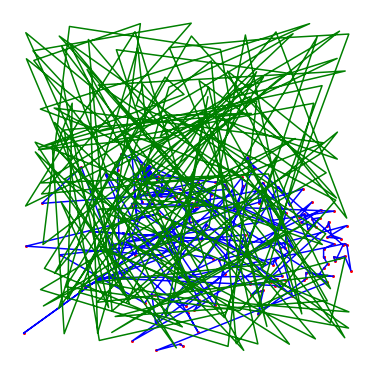

epoch  1   radius:  5
epoch  101   radius:  4.523960735568544
current path distance:  9.275041153977368
(194, 2)


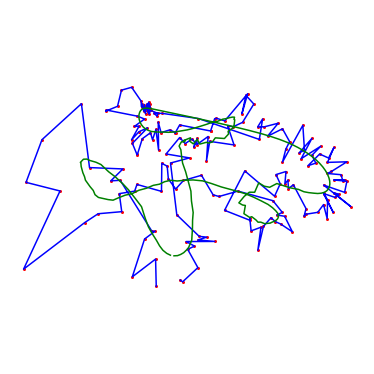

epoch  201   radius:  4.093244147393178
epoch  301   radius:  3.703535160780494
current path distance:  8.743471014549389
(194, 2)


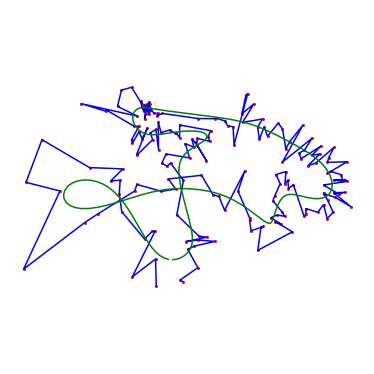

epoch  401   radius:  3.350929530033697
epoch  501   radius:  3.0318947243059187
current path distance:  8.714667845321426
(194, 2)


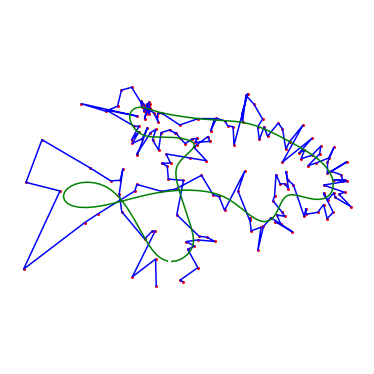

epoch  601   radius:  2.7432345374274782
epoch  701   radius:  2.482057067155491
current path distance:  8.429443147877489
(194, 2)


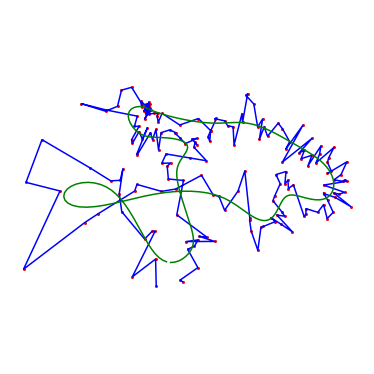

epoch  801   radius:  2.2457457430503736
epoch  901   radius:  2.031933112726019
current path distance:  8.53071788396907
(194, 2)


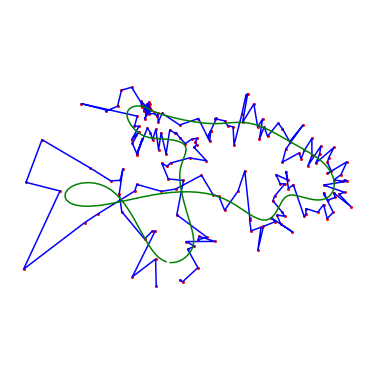

epoch  1001   radius:  1.8384771238548159
epoch  1101   radius:  1.6634396643120348
current path distance:  8.4157995710166
(194, 2)


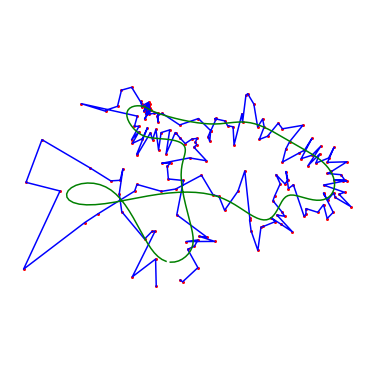

epoch  1201   radius:  1.5050671454669933
epoch  1301   radius:  1.3617729340973814
current path distance:  8.48342623162087
(194, 2)


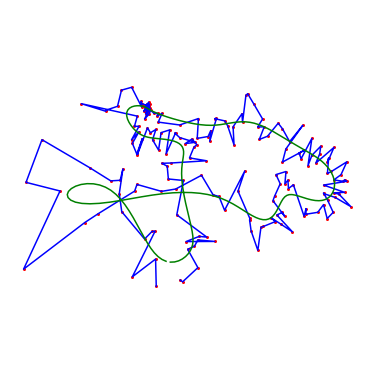

epoch  1401   radius:  1.2321214569233039
epoch  1501   radius:  1.1148138185145067
current path distance:  8.504617161011945
(194, 2)


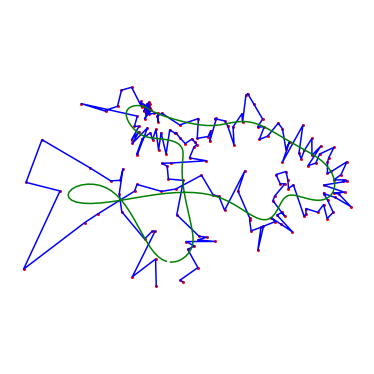

epoch  1601   radius:  1.0086747884857732
epoch  1701   radius:  0.9126410276135087
current path distance:  8.527446123259544
(194, 2)


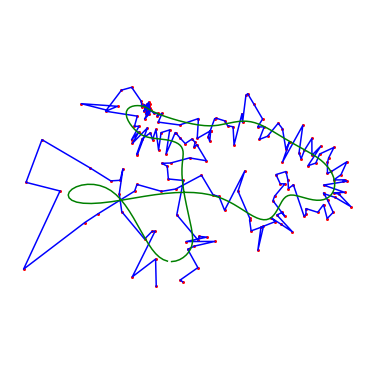

epoch  1801   radius:  0.8257504349184881
epoch  1901   radius:  0.7471325089899775
current path distance:  8.304764075993441
(194, 2)


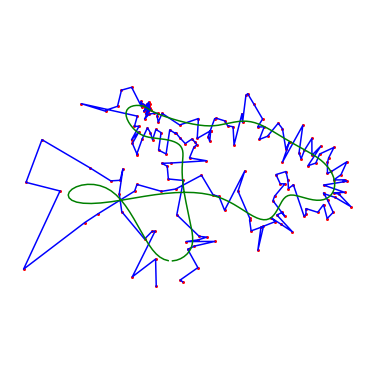

In [10]:
k = Kohonen(len(cities), feature_size=2, radius=5, lr=0.5)
res1 = k.visualize_map(cities_dataset, return_fast=False)

for i in range(10):
  k.train(cities_dataset, 200, decay_radius=True)
  res2 = k.visualize_map(cities_dataset, return_fast=False)